<a href="https://colab.research.google.com/github/pesfahanian/Kaggle_Pneumonia_InceptionV3/blob/main/Kaggle_Pneumonia_InceptionV3_Version2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/MyDrive/Pneumonia/chest_xray

/content/drive/MyDrive/Pneumonia/chest_xray


In [2]:
!ls

EfficientNet2.h5  foo.pdf   model_vgg16.h5  test   val
EfficientNet.h5   __MACOSX  pneumonia.h5    train


In [3]:
import glob
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
from itertools import cycle

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

import keras_preprocessing
from keras.models import load_model
from keras_preprocessing import image
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator

In [4]:
train_path      =   '/content/drive/MyDrive/Pneumonia/chest_xray/train'
validation_path =   '/content/drive/MyDrive/Pneumonia/chest_xray/val'
test_path       =   '/content/drive/MyDrive/Pneumonia/chest_xray/test'

In [5]:
train_NORMAL = len(glob.glob(train_path + '/NORMAL/*'))
train_PNEUMONIA = len(glob.glob(train_path + '/PNEUMONIA/*'))

validation_NORMAL = len(glob.glob(validation_path + '/NORMAL/*'))
validation_PNEUMONIA = len(glob.glob(validation_path + '/PNEUMONIA/*'))

test_NORMAL = len(glob.glob(test_path + '/NORMAL/*'))
test_PNEUMONIA = len(glob.glob(test_path + '/PNEUMONIA/*'))

print('Train:', train_NORMAL, 'NORMAL,', train_PNEUMONIA, 'PNEUMONIA.')
print('Validation:', validation_NORMAL, 'NORMAL,', validation_PNEUMONIA, 'PNEUMONIA.')
print('Test:', test_NORMAL, 'NORMAL,', test_PNEUMONIA, 'PNEUMONIA.')

Train: 1300 NORMAL, 3834 PNEUMONIA.
Validation: 49 NORMAL, 49 PNEUMONIA.
Test: 234 NORMAL, 390 PNEUMONIA.


In [6]:
IMG_SIZE    =   224
num_classes =   2
epochs      =   15
batch_size  =   16

In [7]:
train_datagen = ImageDataGenerator(rescale          =   1./255,
                                   rotation_range   =   15,     # changed this
                                   shear_range      =   0.2,    # changed this
                                   zoom_range       =   0.2,    # changed this
                                   horizontal_flip  =   False)
train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size =   (IMG_SIZE, IMG_SIZE),
                                                    class_mode  =   'categorical',
                                                    batch_size  =   batch_size,
                                                    shuffle     =   True)

validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_directory(validation_path,
                                                              target_size =   (IMG_SIZE, IMG_SIZE),
                                                              class_mode  =   'categorical',
                                                              batch_size  =   batch_size,
                                                              shuffle     =   False)

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size =   (IMG_SIZE, IMG_SIZE),
                                                  class_mode  =   'categorical',
                                                  batch_size  =   batch_size,
                                                  shuffle     =   False)

Found 5134 images belonging to 2 classes.
Found 98 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


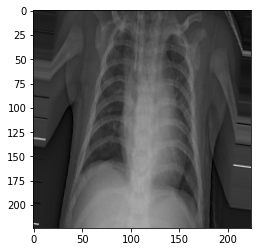

In [8]:
x, y = train_generator.next()
for i in range(0, 1):
    image = x[i]
    plt.imshow(image)
    plt.show()

In [9]:
URL = 'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4' 
feature_extractor = hub.KerasLayer(URL, input_shape=(224, 224, 3))
feature_extractor.trainable = False

In [10]:
model = tf.keras.models.Sequential(
    [
     feature_extractor,
     tf.keras.layers.Dense(64, activation='relu'),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Dense(64, activation='relu'),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Dense(num_classes, activation='softmax')
    ]
)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 64)                131136    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 21,938,210
Trainable params: 135,426
Non-trainable params: 21,802,784
______________________________________

In [12]:
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')]

In [13]:
save_path = "InceptionV3.h5"
checkpoint = ModelCheckpoint(save_path,
                             monitor        =   'val_accuracy',
                             verbose        =   1,
                             save_best_only =   True,
                             mode           =   'max')
callbacks = [checkpoint]

In [14]:
model.compile(optimizer =   tf.optimizers.Adam(learning_rate=0.0001),
              loss      =   'categorical_crossentropy',  # changed this
              metrics   =   METRICS )

In [15]:
history = model.fit(train_generator,
                    epochs              =   epochs,
                    callbacks           =   [callbacks],
                    validation_data     =   validation_generator,
                    use_multiprocessing =   True,
                    workers             =   4)

Epoch 1/15


320/321 [============================>.] - ETA: 2s - loss: 0.4004 - accuracy: 0.8175 - precision: 0.8175 - recall: 0.8175WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


321/321 [==============================] - ETA: 0s - loss: 0.4003 - accuracy: 0.8179 - precision: 0.8179 - recall: 0.8179WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00001: val_accuracy improved from -inf to 0.85714, saving model to InceptionV3.h5
321/321 [==============================] - 812s 3s/step - loss: 0.4003 - accuracy: 0.8179 - precision: 0.8179 - recall: 0.8179 - val_loss: 0.3452 - val_accuracy: 0.8571 - val_precision: 0.8571 - val_recall: 0.8571
Epoch 2/15


321/321 [==============================] - ETA: 0s - loss: 0.2595 - accuracy: 0.8966 - precision: 0.8966 - recall: 0.8966WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00002: val_accuracy did not improve from 0.85714
321/321 [==============================] - 100s 310ms/step - loss: 0.2595 - accuracy: 0.8966 - precision: 0.8966 - recall: 0.8966 - val_loss: 0.3720 - val_accuracy: 0.8469 - val_precision: 0.8469 - val_recall: 0.8469
Epoch 3/15


321/321 [==============================] - ETA: 0s - loss: 0.2142 - accuracy: 0.9108 - precision: 0.9108 - recall: 0.9108WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00003: val_accuracy improved from 0.85714 to 0.88776, saving model to InceptionV3.h5
321/321 [==============================] - 102s 319ms/step - loss: 0.2142 - accuracy: 0.9108 - precision: 0.9108 - recall: 0.9108 - val_loss: 0.3150 - val_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 4/15


321/321 [==============================] - ETA: 0s - loss: 0.2026 - accuracy: 0.9194 - precision: 0.9194 - recall: 0.9194WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00004: val_accuracy did not improve from 0.88776
321/321 [==============================] - 96s 300ms/step - loss: 0.2026 - accuracy: 0.9194 - precision: 0.9194 - recall: 0.9194 - val_loss: 0.2927 - val_accuracy: 0.8776 - val_precision: 0.8776 - val_recall: 0.8776
Epoch 5/15


320/321 [============================>.] - ETA: 0s - loss: 0.1902 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


321/321 [==============================] - ETA: 0s - loss: 0.1898 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00005: val_accuracy did not improve from 0.88776
321/321 [==============================] - 96s 298ms/step - loss: 0.1898 - accuracy: 0.9242 - precision: 0.9242 - recall: 0.9242 - val_loss: 0.2362 - val_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 6/15


321/321 [==============================] - ETA: 0s - loss: 0.1906 - accuracy: 0.9235 - precision: 0.9235 - recall: 0.9235WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00006: val_accuracy did not improve from 0.88776
321/321 [==============================] - 94s 293ms/step - loss: 0.1906 - accuracy: 0.9235 - precision: 0.9235 - recall: 0.9235 - val_loss: 0.2722 - val_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 7/15


320/321 [============================>.] - ETA: 0s - loss: 0.1825 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


321/321 [==============================] - ETA: 0s - loss: 0.1831 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00007: val_accuracy did not improve from 0.88776
321/321 [==============================] - 95s 295ms/step - loss: 0.1831 - accuracy: 0.9346 - precision: 0.9346 - recall: 0.9346 - val_loss: 0.2527 - val_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878
Epoch 8/15


320/321 [============================>.] - ETA: 0s - loss: 0.1728 - accuracy: 0.9324 - precision: 0.9324 - recall: 0.9324WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


321/321 [==============================] - ETA: 0s - loss: 0.1724 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00008: val_accuracy improved from 0.88776 to 0.89796, saving model to InceptionV3.h5
321/321 [==============================] - 103s 321ms/step - loss: 0.1724 - accuracy: 0.9326 - precision: 0.9326 - recall: 0.9326 - val_loss: 0.2430 - val_accuracy: 0.8980 - val_precision: 0.8980 - val_recall: 0.8980
Epoch 9/15


320/321 [============================>.] - ETA: 0s - loss: 0.1657 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


321/321 [==============================] - ETA: 0s - loss: 0.1654 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00009: val_accuracy did not improve from 0.89796
321/321 [==============================] - 98s 304ms/step - loss: 0.1654 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - val_loss: 0.2716 - val_accuracy: 0.8980 - val_precision: 0.8980 - val_recall: 0.8980
Epoch 10/15


320/321 [============================>.] - ETA: 0s - loss: 0.1658 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9349WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00010: val_accuracy improved from 0.89796 to 0.90816, saving model to InceptionV3.h5
321/321 [==============================] - 100s 312ms/step - loss: 0.1662 - accuracy: 0.9347 - precision: 0.9347 - recall: 0.9347 - val_loss: 0.2421 - val_accuracy: 0.9082 - val_precision: 0.9082 - val_recall: 0.9082
Epoch 11/15


320/321 [============================>.] - ETA: 0s - loss: 0.1566 - accuracy: 0.9424 - precision: 0.9424 - recall: 0.9424WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


321/321 [==============================] - ETA: 0s - loss: 0.1579 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00011: val_accuracy did not improve from 0.90816
321/321 [==============================] - 96s 300ms/step - loss: 0.1579 - accuracy: 0.9420 - precision: 0.9420 - recall: 0.9420 - val_loss: 0.2666 - val_accuracy: 0.8980 - val_precision: 0.8980 - val_recall: 0.8980
Epoch 12/15


320/321 [============================>.] - ETA: 0s - loss: 0.1649 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


321/321 [==============================] - ETA: 0s - loss: 0.1651 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00012: val_accuracy did not improve from 0.90816
321/321 [==============================] - 96s 298ms/step - loss: 0.1651 - accuracy: 0.9404 - precision: 0.9404 - recall: 0.9404 - val_loss: 0.2380 - val_accuracy: 0.8980 - val_precision: 0.8980 - val_recall: 0.8980
Epoch 13/15


320/321 [============================>.] - ETA: 0s - loss: 0.1532 - accuracy: 0.9371 - precision: 0.9371 - recall: 0.9371WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


321/321 [==============================] - ETA: 0s - loss: 0.1530 - accuracy: 0.9373 - precision: 0.9373 - recall: 0.9373WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00013: val_accuracy improved from 0.90816 to 0.91837, saving model to InceptionV3.h5
321/321 [==============================] - 98s 306ms/step - loss: 0.1530 - accuracy: 0.9373 - precision: 0.9373 - recall: 0.9373 - val_loss: 0.2270 - val_accuracy: 0.9184 - val_precision: 0.9184 - val_recall: 0.9184
Epoch 14/15


320/321 [============================>.] - ETA: 0s - loss: 0.1474 - accuracy: 0.9400 - precision: 0.9400 - recall: 0.9400WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


321/321 [==============================] - ETA: 0s - loss: 0.1472 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00014: val_accuracy did not improve from 0.91837
321/321 [==============================] - 93s 290ms/step - loss: 0.1472 - accuracy: 0.9402 - precision: 0.9402 - recall: 0.9402 - val_loss: 0.2551 - val_accuracy: 0.9082 - val_precision: 0.9082 - val_recall: 0.9082
Epoch 15/15


320/321 [============================>.] - ETA: 0s - loss: 0.1501 - accuracy: 0.9508 - precision: 0.9508 - recall: 0.9508WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


321/321 [==============================] - ETA: 0s - loss: 0.1502 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.



Epoch 00015: val_accuracy did not improve from 0.91837
321/321 [==============================] - 94s 292ms/step - loss: 0.1502 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9507 - val_loss: 0.2414 - val_accuracy: 0.8878 - val_precision: 0.8878 - val_recall: 0.8878


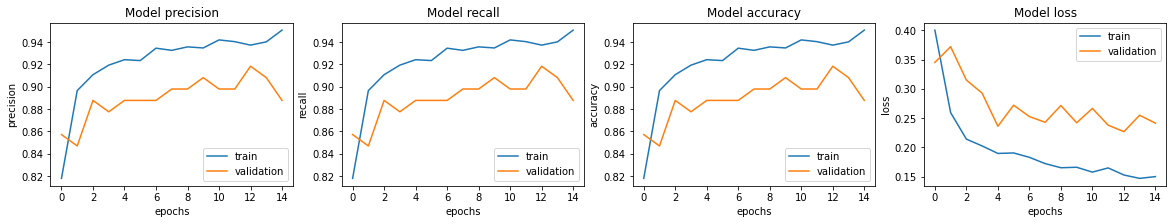

In [17]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'validation'])

In [18]:
model.evaluate(test_generator)

39/39 [==============================] - 294s 8s/step - loss: 0.3676 - accuracy: 0.8622 - precision: 0.8622 - recall: 0.8622


[0.36757540702819824,
 0.8621794581413269,
 0.8621794581413269,
 0.8621794581413269]

In [19]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

Instructions for updating:
Please use Model.predict, which supports generators.


Instructions for updating:
Please use Model.predict, which supports generators.


In [20]:
print('Classification Report:')
target_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.90      0.71      0.79       234
   PNEUMONIA       0.85      0.95      0.90       390

    accuracy                           0.86       624
   macro avg       0.87      0.83      0.85       624
weighted avg       0.87      0.86      0.86       624



In [21]:
def plot_confusion_matrix(cm,
                          classes,
                          normalize =   False,
                          title     =   'Confusion matrix',
                          cmap      =   plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes, rotation=90, va="center")

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            fontsize = 15,
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


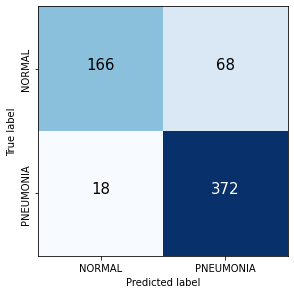

In [22]:
cm = confusion_matrix(test_generator.classes, y_pred)
cm_plot_labels = ['NORMAL', 'PNEUMONIA']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='')